In [ ]:
import pandas as pd

# Function to calculate channel utilization

def calculate_channel_utilization(df):
    """Calculate channel utilization as the percentage of time the channel is actively being used.
    
    Args:
    - df (DataFrame): DataFrame containing channel data.

    Returns:
    - channel_utilization (float): Channel utilization as a percentage.
    """
    # Ensure the 'time' and 'Duration' columns are numeric
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')


    # Calculate the total duration for which the channel was busy
    # Assuming Duration is in microseconds, convert it to seconds for calculation
    total_busy_time = df['Duration'].sum() / 1e6  # Convert microseconds to seconds
  
    # Calculate the total time of the capture
    total_time = df['Time'].max() - df['Time'].min()  # Total capture time in seconds
    
    # Calculate channel utilization as a percentage
    if total_time > 0:
        channel_utilization = (total_busy_time / total_time) * 100
    else:
        channel_utilization = 0

    return channel_utilization


In [ ]:
# Define a function to calculate latency
# most congested network
csv_file_path = './main-data/11.4-Mon/csv/mainlib-6-night.csv'  

# Function to calculate the latency
def calculate_latency(df):
    # Convert 'Time' column to numeric type
    df['Time'] = pd.to_numeric(df['Time'], errors='coerce')

    # Filter ACK and data packets
    ack_packets = df[df['Type/Subtype'].str.contains('Acknowledgement', case=False, na=False)].copy()
    data_packets = df[~df['Type/Subtype'].str.contains('Acknowledgement', case=False, na=False)].copy()

    # Sort packets by time
    ack_packets.sort_values(by='Time', inplace=True)
    data_packets.sort_values(by='Time', inplace=True)

    # Initialize latency column
    df['latency'] = pd.NA

    # Iterate over data packets
    for _, data_packet in data_packets.iterrows():
        # Find the first ACK packet where Time > data packet and Destination == data packet's Source
        corresponding_ack = ack_packets[
            (ack_packets['Time'] > data_packet['Time']) & 
            (ack_packets['Destination'] == data_packet['Source'])
        ].head(1)

        if not corresponding_ack.empty:
            ack_packet = corresponding_ack.iloc[0]
            latency = ack_packet['Time'] - data_packet['Time']
            df.at[data_packet.name, 'latency'] = latency

    return df


In [3]:
# calculate the efficiency

df = pd.read_csv(csv_file_path)

# Ensure the 'Length' column is numeric for calculation purposes
df['Length'] = pd.to_numeric(df['Length'], errors='coerce')

# Step 1: Calculate Useful Data Transmitted
# Filter to get non-retransmission packets, assuming non-retransmission packets are marked with "Frame is not being retransmitted"
useful_data_packets = df[df['Retry'] == 'Frame is not being retransmitted']
useful_data_transmitted = useful_data_packets['Length'].sum()

# Step 2: Calculate Total Data Transmitted
# Sum the 'Length' column for all packets, including retransmissions
total_data_transmitted = df['Length'].sum()

# Step 3: Calculate Efficiency
# Efficiency is the ratio of useful data to total data transmitted
if total_data_transmitted > 0:
    efficiency = useful_data_transmitted / total_data_transmitted
else:
    efficiency = 0

# Print the results
print(f"Total Data Transmitted: {total_data_transmitted} Bytes")
print(f"Useful Data Transmitted: {useful_data_transmitted} Bytes")
print(f"Network Efficiency: {efficiency:.2f}")

Total Data Transmitted: 19694563 Bytes
Useful Data Transmitted: 16939022 Bytes
Network Efficiency: 0.86


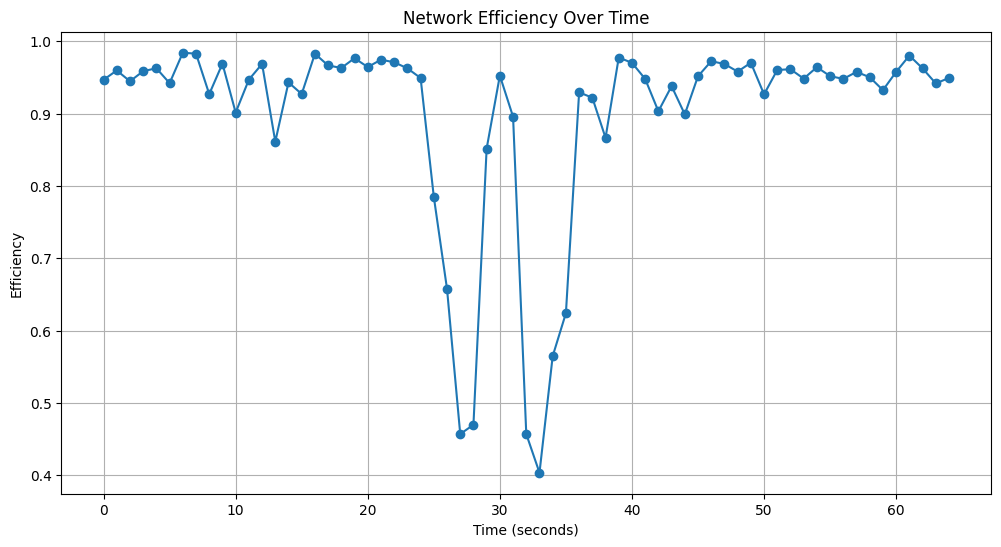

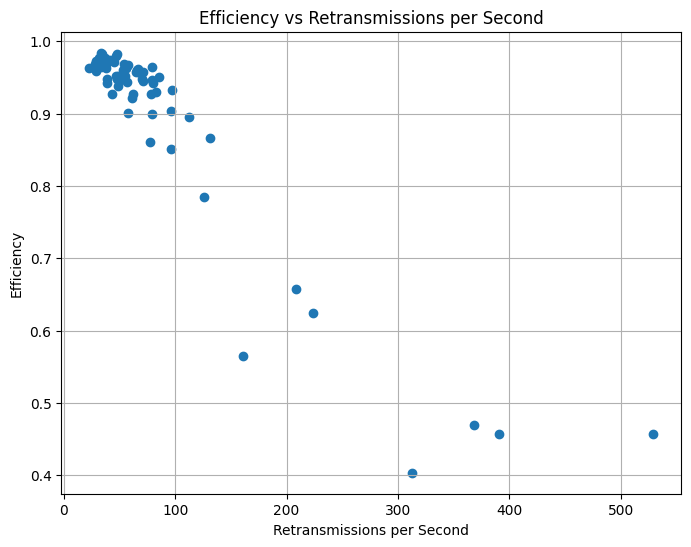

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# plot 
df = pd.read_csv(csv_file_path)


df['Length'] = pd.to_numeric(df['Length'], errors='coerce')


df['Time'] = pd.to_numeric(df['Time'], errors='coerce')


df['Time_bin'] = df['Time'].astype(int)

useful_data_packets = df[df['Retry'] == 'Frame is not being retransmitted']
useful_data_per_second = useful_data_packets.groupby('Time_bin')['Length'].sum()


total_data_per_second = df.groupby('Time_bin')['Length'].sum()


efficiency_per_second = useful_data_per_second / total_data_per_second
efficiency_per_second = efficiency_per_second.fillna(0)


plt.figure(figsize=(12, 6))
plt.plot(efficiency_per_second.index, efficiency_per_second.values, marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Efficiency')
plt.title('Network Efficiency Over Time')
plt.grid(True)
plt.show()

retransmission_packets = df[df['Retry'] == 'Frame is being retransmitted']
retransmissions_per_second = retransmission_packets.groupby('Time_bin')['Length'].count()
retransmissions_per_second = retransmissions_per_second.reindex(total_data_per_second.index, fill_value=0)

plt.figure(figsize=(8, 6))
plt.scatter(retransmissions_per_second.values, efficiency_per_second.values)
plt.xlabel('Retransmissions per Second')
plt.ylabel('Efficiency')
plt.title('z per Second')
plt.grid(True)
plt.show()


In [ ]:
# calculate the latency
path = './main-data/11.4-Mon/csv/mainlib-6-night.csv'  
try:
    df = pd.read_csv(path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(path, encoding='latin1')
    
df_l = calculate_latency(df)


In [6]:
df_l

,No.,Time,Source,Destination,Length,Signal strength (RSSI),Retry,Type/Subtype,SSID,Channel,Frame Number,Duration,Data rate,Info,Sequence number,location,weather,channel utilization,datetime,latency
0,1,0.000000,NaN,3e:9c:fc:6c:0f:86,68,-71 dBm,Frame is not being retransmitted,Clear-to-send,NaN,6,1,304,1.0,"Clear-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,<NA>
1,2,0.001534,3e:9c:fc:6c:0f:86,Apple_5a:b2:4c,76,-85 dBm,Frame is not being retransmitted,Request-to-send,NaN,6,2,111,11.0,"Request-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,2.598235
2,3,0.001553,NaN,3e:9c:fc:6c:0f:86,68,-71 dBm,Frame is not being retransmitted,Clear-to-send,NaN,6,3,107,11.0,"Clear-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,<NA>
3,4,0.001567,Apple_5a:b2:4c,3e:9c:fc:6c:0f:86,68,-72 dBm,Frame is not being retransmitted,802.11 Block Ack,NaN,6,4,32,24.0,"802.11 Block Ack, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,2.804525
4,5,0.002871,Apple_5a:b2:4c,3e:9c:fc:6c:0f:86,76,-71 dBm,Frame is not being retransmitted,Request-to-send,NaN,6,5,111,11.0,"Request-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,2.803221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98576,98577,64.624032,3e:e1:a6:9a:ca:82,ff:ff:ff:ff:ff:ff,390,-73 dBm,Frame is not being retransmitted,Action,NaN,6,98577,260,12.0,Periodic Synchronization,988.0,main library,sunny,37.603982,2024/11/04 Mon,<NA>
98577,98578,64.624046,Apple_c3:40:16,e2:68:3d:a2:dd:3a,76,-82 dBm,Frame is not being retransmitted,Request-to-send,NaN,6,98578,111,11.0,"Request-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,<NA>
98578,98579,64.626751,be:d5:b5:57:f1:da,ff:ff:19:83:07:7c,295,-83 dBm,Frame is not being retransmitted,Beacon frame,"""iPhone""",6,98579,2264,1.0,"Beacon frame, SN=3086, FN=0, Flags=........C, ...",3086.0,main library,sunny,37.603982,2024/11/04 Mon,<NA>
98579,98580,64.627876,Apple_c3:40:16,e2:68:3d:a2:dd:3a,76,-84 dBm,Frame is not being retransmitted,Request-to-send,NaN,6,98580,111,11.0,"Request-to-send, Flags=........C",NaN,main library,sunny,37.603982,2024/11/04 Mon,<NA>


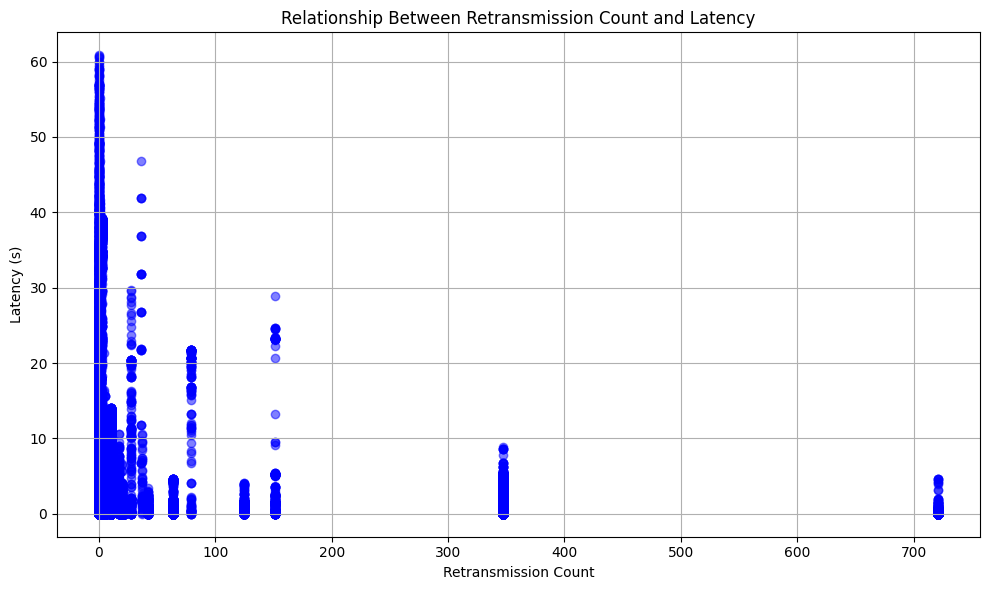

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


if 'is_retransmission' not in df_l.columns:

    df_l['is_retransmission'] = df_l['Retry'].apply(lambda x: 0 if 'not being retransmitted' in str(x).lower() else 1)


df_l['retransmission_count'] = df_l.groupby(['Source', 'Destination'])['is_retransmission'].transform('sum')

filtered_df = df_l.dropna(subset=['latency'])

# plt
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['retransmission_count'], filtered_df['latency'], color='blue', alpha=0.5)
plt.xlabel('Retransmission Count')
plt.ylabel('Latency (s)')
plt.title('Relationship Between Retransmission Count and Latency')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

try:
    df = pd.read_csv(csv_file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding='latin1')


df['Time'] = pd.to_numeric(df['Time'], errors='coerce')


all_macs = pd.concat([df['Source'], df['Destination']])

mac_packet_counts = all_macs.value_counts()


print("Top 10 MAC Addresses by Packet Count:")
print(mac_packet_counts.head(10))


df['MAC'] = df['Source']
destination_only = df.copy()
destination_only['MAC'] = destination_only['Destination']
df = pd.concat([df, destination_only], ignore_index=True)


mac_data_volumes = df.groupby('MAC')['Length'].sum()


mac_data_volumes_sorted = mac_data_volumes.sort_values(ascending=False)
print("\nTop 10 MAC Addresses by Data Volume:")
print(mac_data_volumes_sorted.head(10))


Top 10 MAC Addresses by Packet Count:
Apple_5a:b2:4c       24560
ff:ff:ff:ff:ff:ff    23967
3e:9c:fc:6c:0f:86    21609
Apple_8a:89:b4        6066
e2:68:3d:a2:dd:3a     5414
Apple_c3:40:16        4505
aa:ab:b5:a8:f7:64     3804
86:6c:66:bc:05:36     3350
Intel_bf:f2:2a        3301
92:7e:88:a7:dc:60     3217
Name: count, dtype: int64

Top 10 MAC Addresses by Data Volume:
MAC
ff:ff:ff:ff:ff:ff    8780166
Apple_5a:b2:4c       3222012
Apple_8a:89:b4       2867571
9a:60:ca:75:0d:64    2663643
aa:ab:b5:a8:f7:64    1716005
3e:9c:fc:6c:0f:86    1574695
e2:68:3d:a2:dd:3a     410073
Intel_bf:f2:2a        359647
Apple_c3:40:16        336314
86:6c:66:bc:05:36     329051
Name: Length, dtype: int64


In [ ]:

# calculate the throughput
try:
    df = pd.read_csv(csv_file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding='latin1')


df['Time'] = pd.to_numeric(df['Time'], errors='coerce')

mac_addresses = ['ff:ff:ff:ff:ff:ff', 'Apple_5a:b2:4c', 'Apple_8a:89:b4']  

device_packets = df[(df['Source'].isin(mac_addresses)) | (df['Destination'].isin(mac_addresses))]

total_data_transmitted = device_packets['Length'].sum()

capture_duration = df['Time'].max() - df['Time'].min() 


if capture_duration > 0:
    throughput = total_data_transmitted / capture_duration 
else:
    throughput = 0


print(f"Total Data Transmitted: {total_data_transmitted} Bytes")
print(f"Capture Duration: {capture_duration} seconds")
print(f"Throughput: {throughput:.2f} Bytes/second")



Total Data Transmitted: 14868969 Bytes
Capture Duration: 64.627897 seconds
Throughput: 230070.44 Bytes/second


C:\Users\39851\AppData\Local\Temp\ipykernel_4236\1489452712.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_packets['Time_bin'] = device_packets['Time'].astype(int)


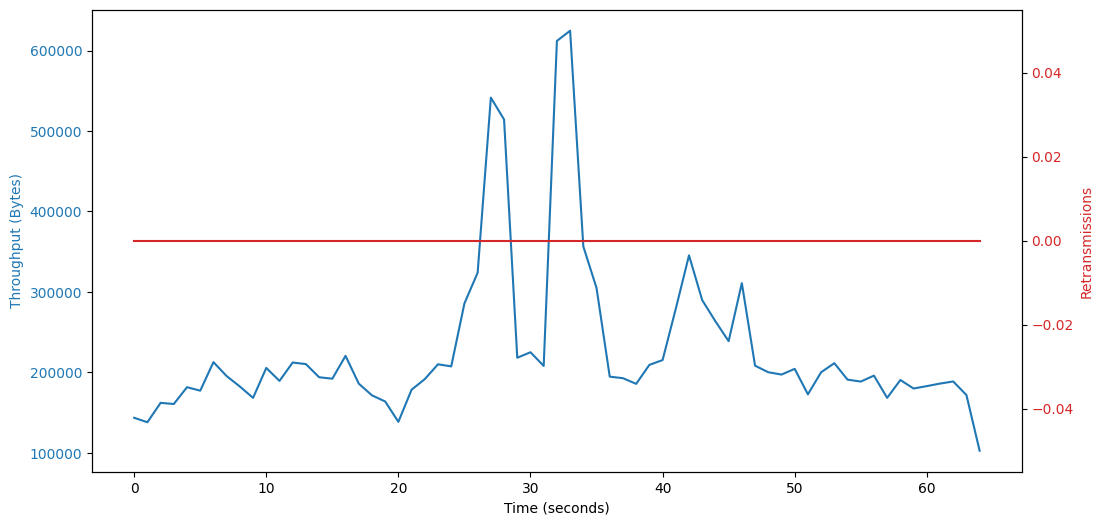

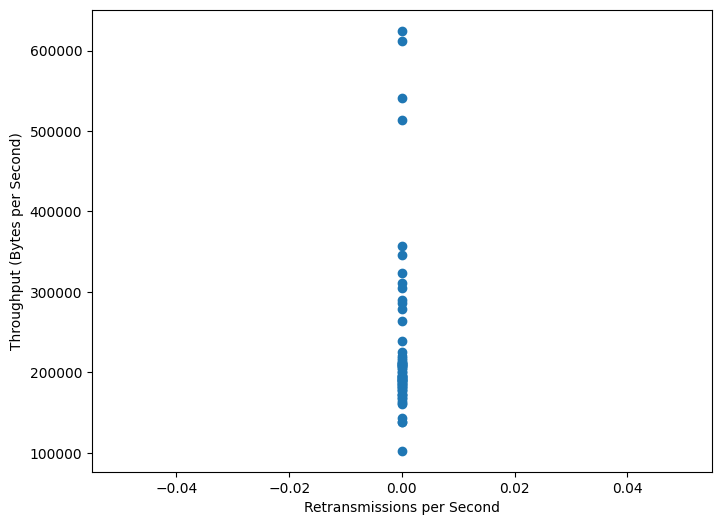

In [10]:
import pandas as pd
import matplotlib.pyplot as plt


try:
    df = pd.read_csv(csv_file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(csv_file_path, encoding='latin1')


df['Time'] = pd.to_numeric(df['Time'], errors='coerce')


mac_addresses = ['ff:ff:ff:ff:ff:ff', 'Apple_5a:b2:4c', 'Apple_8a:89:b4']  


device_packets = df[(df['Source'].isin(mac_addresses)) | (df['Destination'].isin(mac_addresses))]


device_packets['Time_bin'] = device_packets['Time'].astype(int)

throughput_per_second = device_packets.groupby('Time_bin')['Length'].sum()

retransmitted_packets = device_packets[device_packets['Info'].str.contains('Retransmission', na=False)]


retransmissions_per_second = retransmitted_packets.groupby('Time_bin')['Length'].count()

metrics_df = pd.DataFrame({
    'Throughput': throughput_per_second,
    'Retransmissions': retransmissions_per_second
}).fillna(0)

metrics_df.index = metrics_df.index.astype(int)
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Throughput (Bytes)', color='tab:blue')
ax1.plot(metrics_df.index, metrics_df['Throughput'], color='tab:blue', label='Throughput')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Retransmissions', color='tab:red')
ax2.plot(metrics_df.index, metrics_df['Retransmissions'], color='tab:red', label='Retransmissions')
ax2.tick_params(axis='y', labelcolor='tab:red')


plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(metrics_df['Retransmissions'], metrics_df['Throughput'])
plt.xlabel('Retransmissions per Second')
plt.ylabel('Throughput (Bytes per Second)')

plt.show()



In [11]:
import re

# Function to clean up the Duration column
def clean_duration(duration_str):
    # Use regular expression to extract numeric values
    match = re.search(r'\d+', str(duration_str))
    if match:
        return int(match.group())
    else:
        return 0  # Return 0 if no number is found

In [12]:
import os
import pandas as pd
from datetime import datetime

# The main directory path
main_directory = './main-data'  

# List to store all DataFrames from CSV files
csv_list = []
channel_utilization_list = []
file_name = []

# Iterate through all subdirectories in the main directory
for subdirectory in os.listdir(main_directory):
    subdirectory_path = os.path.join(main_directory, subdirectory)
    if os.path.isdir(subdirectory_path):
        csv_folder_path = os.path.join(subdirectory_path, 'csv')
        if os.path.exists(csv_folder_path) and os.path.isdir(csv_folder_path):
            # Extract date and day information from the subdirectory name
            try:
                date_str, day_str = subdirectory.split('-')
                date_obj = datetime.strptime(date_str, '%m.%d')
                year = 2024  # Fixed year as 2024, can be modified as needed
                date_obj = date_obj.replace(year=year)
                datetime_value = f"{date_obj.strftime('%Y/%m/%d')} {day_str.title()}"
            except ValueError:
                datetime_value = 'unknown'

            # Iterate through all CSV files in the csv folder
            for file in os.listdir(csv_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(csv_folder_path, file)
                    # Read CSV file and add the location column
                    try:
                        df = pd.read_csv(file_path, encoding='utf-8')
                    except UnicodeDecodeError:
                        df = pd.read_csv(file_path, encoding='latin1')
                    
                    # Add the location column, determining if it's main library or law library based on the filename
                    if 'main' in file.lower():
                        df['location'] = 'main library'
                    elif 'law' in file.lower():
                        df['location'] = 'law library'
                    else:
                        df['location'] = 'unknown'
                    
                    # Add weather column based on the subdirectory name
                    if 'Thu' or 'Fri' in subdirectory:
                        df['weather'] = 'sunny'
                    else:
                        df['weather'] = 'cloudy'
                    
                    channel_utilization_value = calculate_channel_utilization(df)
                    channel_utilization_list.append(channel_utilization_value)
                    file = f"{file} {subdirectory}"
                    file_name.append(file)
                    # Add the calculated channel utilization as a new column
                    df['channel utilization'] = channel_utilization_value
                    # Add datetime column with date and day information from the subdirectory
                    df['datetime'] = datetime_value
                    df['Duration'] = df['Duration'].apply(clean_duration)
                        
                    # Replace the original CSV file with the updated DataFrame
                    df.to_csv(file_path, index=False)
                    
                    # Append updated DataFrame to the list
                    try:
                        csv_list.append(pd.read_csv(file_path, encoding='utf-8'))
                    except UnicodeDecodeError:
                        csv_list.append(pd.read_csv(file_path, encoding='latin1'))

# Merge all DataFrames into one
merged_csv = pd.concat(csv_list, ignore_index=True)

# Save the merged DataFrame to a CSV file
output_path = './main-data/merged.csv'  # Replace with your output path
merged_csv.to_csv(output_path, index=False)

print(f"CSV files merged successfully and saved to {output_path}")
print("CSV files updated successfully with the 'location' and 'datetime' columns.")


CSV files merged successfully and saved to ./main-data/merged.csv
CSV files updated successfully with the 'location' and 'datetime' columns.


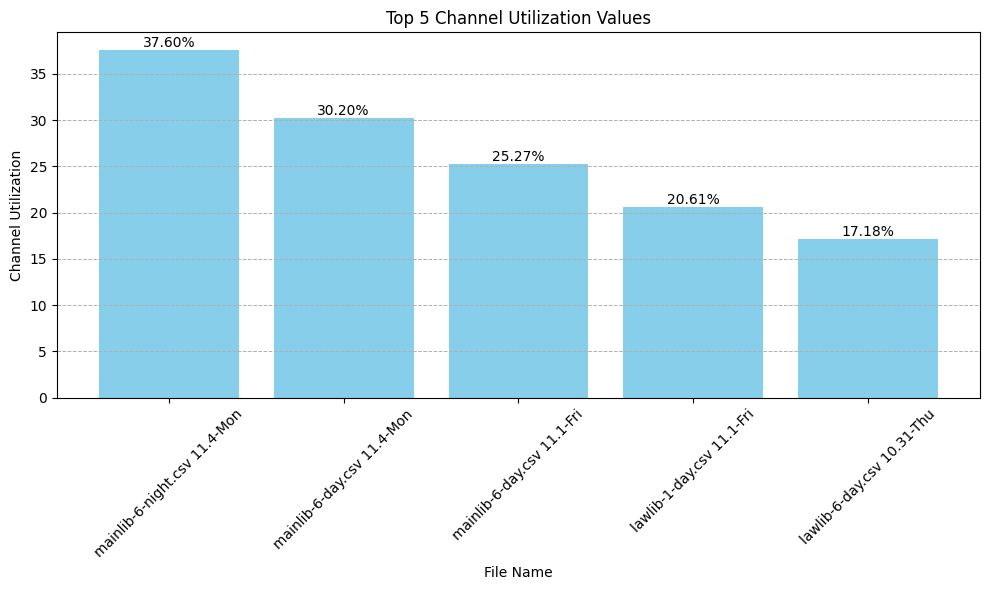

In [13]:
import matplotlib.pyplot as plt

# Combine the two lists into a list of tuples
combined_list = list(zip(channel_utilization_list, file_name))

# Sort the combined list by channel utilization in descending order
sorted_combined_list = sorted(combined_list, key=lambda x: x[0], reverse=True)

# Select the top 5
top5_combined_list = sorted_combined_list[:5]

# Unzip the top 5 list back into separate lists
top5_channel_utilization_list, top5_file_name = zip(*top5_combined_list)

# Plotting the top 5 channel utilization values
plt.figure(figsize=(10, 6))
plt.bar(top5_file_name, top5_channel_utilization_list, color='skyblue')

bars = plt.bar(top5_file_name, top5_channel_utilization_list, color='skyblue')
# Add text labels on top of each bar to show the exact value
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f'{bar.get_height():.2f}%', ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel('File Name')
plt.ylabel('Channel Utilization')
plt.title('Top 5 Channel Utilization Values')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


In [14]:

sampled_csv = merged_csv.sample(frac=0.3, random_state=42)


sampled_output_path = './main-data/split_combined.csv'
sampled_csv.to_csv(sampled_output_path, index=False)

In [15]:
# read files with pandas
import pandas as pd
df = pd.read_csv('./main-data/merged.csv', encoding='latin1', index_col=0)

# show the df basic info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2258937 entries, 1 to 1454
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Time                    float64
 1   Source                  object 
 2   Destination             object 
 3   Length                  int64  
 4   Signal strength (RSSI)  object 
 5   Retry                   object 
 6   Type/Subtype            object 
 7   SSID                    object 
 8   Channel                 int64  
 9   Frame Number            int64  
 10  Duration                int64  
 11  Data rate               float64
 12  Info                    object 
 13  Sequence number         float64
 14  location                object 
 15  weather                 object 
 16  channel utilization     float64
 17  datetime                object 
dtypes: float64(4), int64(4), object(10)
memory usage: 327.5+ MB


,Time,Length,Channel,Frame Number,Duration,Data rate,Sequence number,channel utilization
count,2.258937e+06,2.258937e+06,2.258937e+06,2.258937e+06,2.258937e+06,2.258928e+06,1.474839e+06,2.258937e+06
mean,9.792793e+01,3.085194e+02,5.216575e+00,3.040668e+04,3.163948e+02,1.687387e+01,1.985636e+03,1.129965e+01
std,9.273296e+01,3.410736e+02,3.802363e+00,2.427076e+04,4.531657e+02,2.660368e+01,1.206441e+03,8.895220e+00
min,0.000000e+00,4.000000e+01,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,6.876494e-02
25%,3.458734e+01,6.400000e+01,1.000000e+00,1.009600e+04,6.800000e+01,1.100000e+01,9.330000e+02,4.734471e+00
50%,7.182772e+01,3.080000e+02,6.000000e+00,2.578300e+04,2.520000e+02,1.200000e+01,1.970000e+03,8.838930e+00
75%,1.294074e+02,4.090000e+02,6.000000e+00,4.598600e+04,2.800000e+02,1.200000e+01,3.029000e+03,1.633514e+01
max,6.098991e+02,3.336000e+03,1.300000e+01,1.141870e+05,1.222400e+04,2.438000e+02,4.095000e+03,3.760398e+01


In [16]:
# read files with pandas
import pandas as pd
df = pd.read_csv('./main-data/split_combined.csv', encoding='latin1', index_col=0)

# show the df basic info
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 677681 entries, 11971 to 7044
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    677681 non-null  float64
 1   Source                  551492 non-null  object 
 2   Destination             675689 non-null  object 
 3   Length                  677681 non-null  int64  
 4   Signal strength (RSSI)  677681 non-null  object 
 5   Retry                   675546 non-null  object 
 6   Type/Subtype            675838 non-null  object 
 7   SSID                    318112 non-null  object 
 8   Channel                 677681 non-null  int64  
 9   Frame Number            677681 non-null  int64  
 10  Duration                677681 non-null  int64  
 11  Data rate               677679 non-null  float64
 12  Info                    677681 non-null  object 
 13  Sequence number         442064 non-null  float64
 14  location               

,Time,Length,Channel,Frame Number,Duration,Data rate,Sequence number,channel utilization
count,677681.000000,677681.000000,677681.000000,677681.000000,677681.000000,677679.000000,442064.000000,677681.000000
mean,97.935794,308.725056,5.219205,30420.461235,316.093529,16.934676,1986.650053,11.300612
std,92.759400,341.728553,3.803625,24282.777662,453.422011,26.757449,1206.539850,8.894419
min,0.000000,40.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.068765
25%,34.572869,64.000000,1.000000,10115.000000,68.000000,11.000000,935.000000,4.734471
50%,71.846251,308.000000,6.000000,25774.000000,252.000000,12.000000,1971.000000,8.838930
75%,129.431571,409.000000,6.000000,46017.000000,280.000000,12.000000,3028.000000,16.335141
max,609.899100,3336.000000,13.000000,114187.000000,12224.000000,243.800000,4095.000000,37.603982


[0 1]


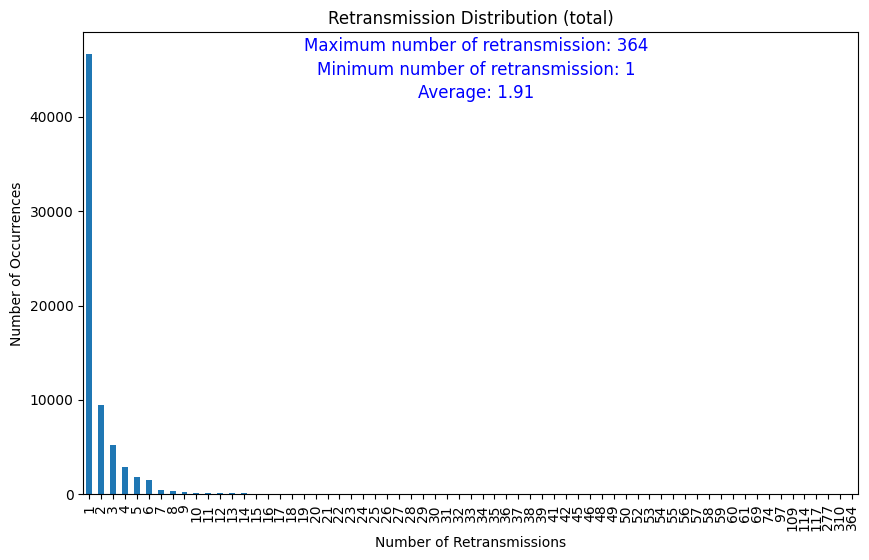

[0 1]


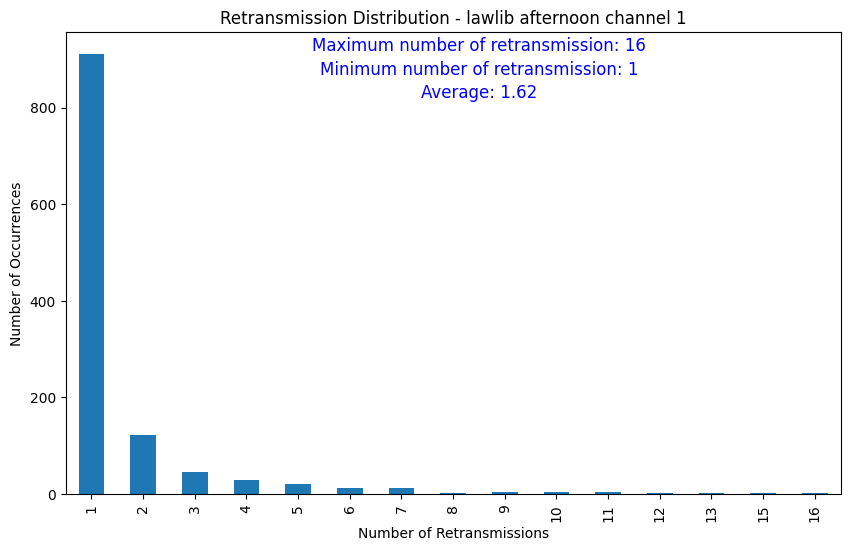

[0 1]


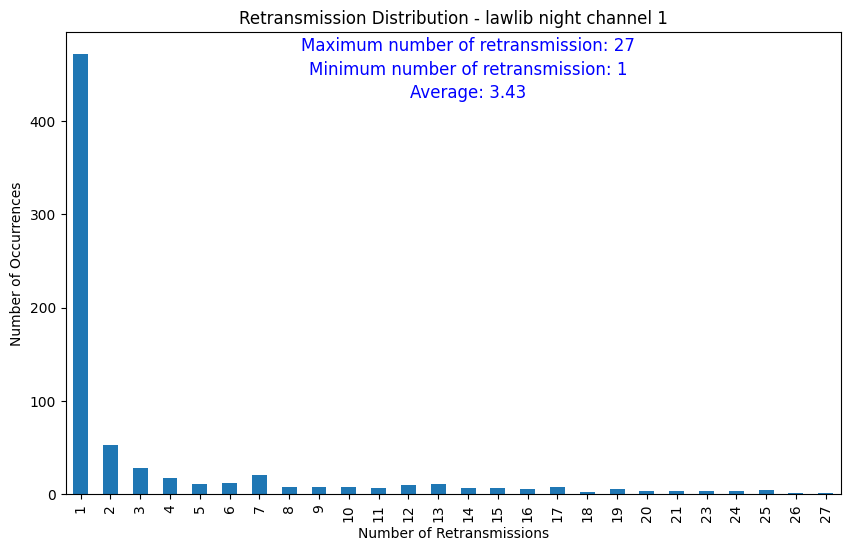

[0 1]


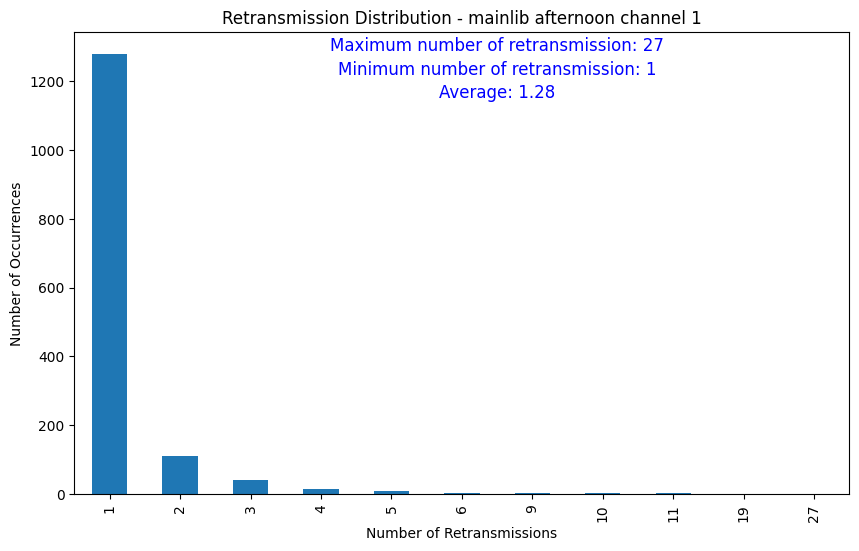

In [17]:
import matplotlib.pyplot as plt

# Function to process the 'Retry' column
def process_retry(x):
    # Ensure x is a string
    if isinstance(x, str):  
        if 'not being retransmitted' in x:
            return 0
        else:
            return 1
    else:
        return 1  

def retransmission_analysis(path,description):
    # Read the CSV file and process retransmission flag
    # df = pd.read_csv('./main-data/sampled_combined.csv', encoding='latin1', index_col=0)
    df = pd.read_csv(path, encoding='latin1', index_col=0)



    # Apply the function to the 'Retry' column
    df['Retry'] = df['Retry'].apply(process_retry)
    print(df['Retry'].unique())

    # Mark retransmitted packets
    df['is_retransmission'] = df['Retry'] == 1

    # Record the number of retransmissions of each packet by Source, Destination, and Sequence number
    retransmission_counts = df[df['is_retransmission']].groupby(['Source', 'Destination', 'Sequence number']).size().reset_index(name='Retransmission_Count')

    # Calculate statistics: max, min, and mean of retransmissions
    max_retransmission = retransmission_counts['Retransmission_Count'].max()
    min_retransmission = retransmission_counts['Retransmission_Count'].min()
    mean_retransmission = retransmission_counts['Retransmission_Count'].mean()

    # Plot retransmission distribution
    plt.figure(figsize=(10, 6))

    # Plot the bar chart
    ax = retransmission_counts['Retransmission_Count'].value_counts().sort_index().plot(kind='bar')

    # Get the current Y-axis maximum value
    y_max = plt.ylim()[1]

    # Add annotations for maximum, minimum, and average retransmission values dynamically
    plt.text(len(retransmission_counts['Retransmission_Count'].value_counts()) / 2, y_max * 0.95,
            f'Maximum number of retransmission: {max_retransmission}', color='blue', ha='center', va='bottom', fontsize=12)

    plt.text(len(retransmission_counts['Retransmission_Count'].value_counts()) / 2, y_max * 0.90,
            f'Minimum number of retransmission: {min_retransmission}', color='blue', ha='center', va='bottom', fontsize=12)

    plt.text(len(retransmission_counts['Retransmission_Count'].value_counts()) / 2, y_max * 0.85,
            f'Average: {mean_retransmission:.2f}', color='blue', ha='center', va='bottom', fontsize=12)

    # Set labels and title for the chart
    plt.xlabel("Number of Retransmissions")
    plt.ylabel("Number of Occurrences")
    plt.title(f"{description}")

    # Show the plot
    plt.show()
    
    
retransmission_analysis('./main-data/merged.csv','Retransmission Distribution (total)')
retransmission_analysis('./main-data/11.4-Mon/csv/lawlib-1-day.csv','Retransmission Distribution - lawlib afternoon channel 1')
retransmission_analysis('./main-data/11.4-Mon/csv/lawlib-1-night.csv','Retransmission Distribution - lawlib night channel 1')
retransmission_analysis('./main-data/11.4-Mon/csv/mainlib-1-day.csv','Retransmission Distribution - mainlib afternoon channel 1')



In [18]:
df['Retry'] = df['Retry'].apply(process_retry)


In [19]:
df

,Time,Source,Destination,Length,Signal strength (RSSI),Retry,Type/Subtype,SSID,Channel,Frame Number,Duration,Data rate,Info,Sequence number,location,weather,channel utilization,datetime
No.,,,,,,,,,,,,,,,,,,
11971,150.230406,HewlettPacka_7a:b4:35,d2:9d:4a:ad:07:15,393,-76 dBm,0,Probe Response,"""Global_Students""",11,11971,260,12.000,"Probe Response, SN=3474, FN=0, Flags=........C...",3474.0,main library,sunny,2.281361,2024/11/01 Fri
7017,14.188295,HewlettPacka_8c:aa:b0,c2:4f:8e:bd:ad:c8,381,-71 dBm,0,Probe Response,"""UNSW Guest""",6,7017,252,12.000,"Probe Response, SN=203, FN=0, Flags=........C,...",203.0,law library,sunny,16.335141,2024/11/01 Fri
18326,213.128256,HewlettPacka_7a:b4:34,ff:ff:ff:ff:ff:ff,396,-78 dBm,0,Beacon frame,"""UNSW Guest""",11,18326,264,12.000,"Beacon frame, SN=1679, FN=0, Flags=........C, ...",1679.0,main library,sunny,2.281361,2024/11/01 Fri
3757,12.392659,HewlettPacka_8f:6c:43,ff:ff:ff:ff:ff:ff,372,-83 dBm,0,Beacon frame,<MISSING>,11,3757,248,12.000,"Beacon frame, SN=1336, FN=0, Flags=........C, ...",1336.0,law library,sunny,9.100926,2024/11/04 Mon
14818,184.866419,HewlettPacka_7a:b4:31,ff:ff:ff:ff:ff:ff,424,-74 dBm,0,Beacon frame,"""uniwide""",11,14818,280,12.000,"Beacon frame, SN=29, FN=0, Flags=........C, BI...",29.0,main library,sunny,2.281361,2024/11/01 Fri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17089,69.879496,HewlettPacka_39:39:b5,ff:ff:ff:ff:ff:ff,438,-69 dBm,0,Beacon frame,"""eduroam""",1,17089,292,12.000,"Beacon frame, SN=3738, FN=0, Flags=........C, ...",3738.0,main library,sunny,6.330777,2024/10/31 Thu
28166,31.584460,Apple_72:cf:0e,aa:9c:78:38:93:64,1545,-60 dBm,0,QoS Data,NaN,6,28166,126,144.444,"QoS Data, SN=1890, FN=0, Flags=.p.....TC",1890.0,main library,sunny,25.269390,2024/11/01 Fri
38223,200.805293,Cisco_b4:80:e2,ff:ff:ff:ff:ff:ff,325,-79 dBm,0,Beacon frame,"""Global_Students""",1,38223,216,12.000,"Beacon frame, SN=2937, FN=0, Flags=........C, ...",2937.0,law library,sunny,4.733988,2024/10/31 Thu


In [20]:
# check the "Retry" distribution
print(df['Retry'].value_counts())

Retry
0    632360
1     45321
Name: count, dtype: int64


<Axes: xlabel='SSID,Retry'>

C:\Users\39851\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\events.py:82: UserWarning: Glyph 134 (\x86) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\39851\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 134 (\x86) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


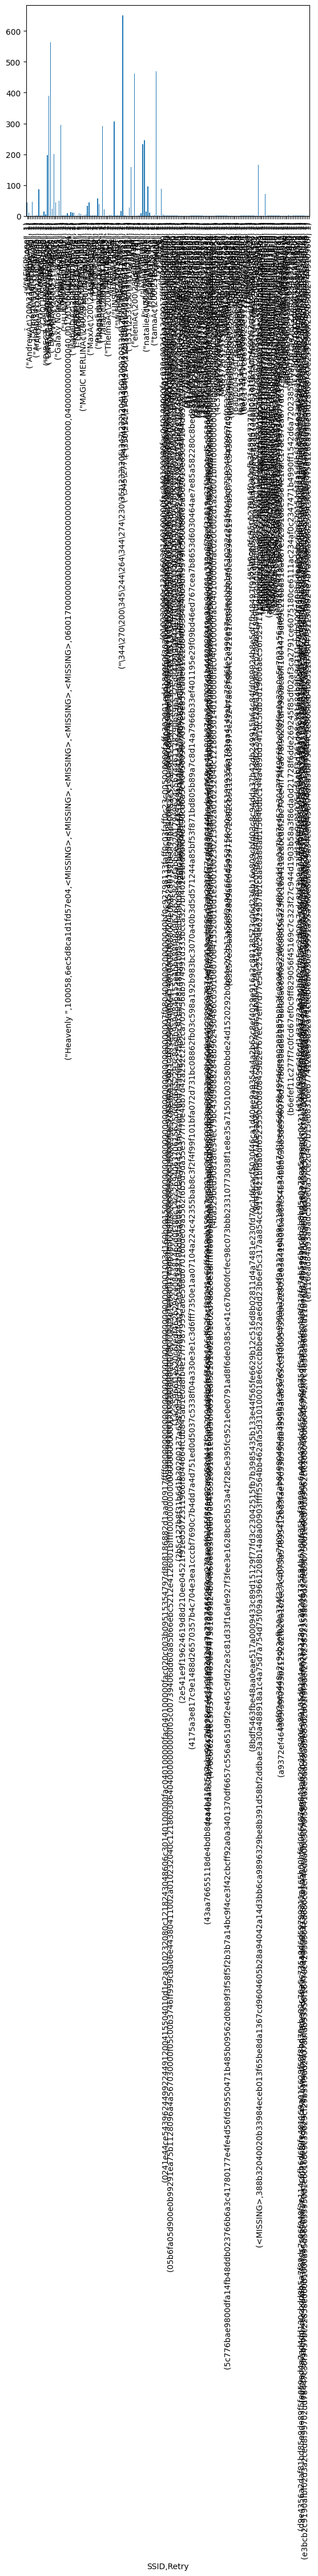

In [21]:
# # show the distributions of "Retry" groupby APs
df.groupby('SSID')['Retry'].value_counts()
# plot the bar chart for "Frame is being retransmitted" (filter the not retransmission packets)
df[df['Retry'] == 1].groupby('SSID')['Retry'].value_counts().plot(kind='bar')


In [22]:

# what is the retransmission rate for each AP?
df.groupby('SSID')['Retry'].value_counts(normalize=True)


SSID                                                              Retry
"  \345\260\217\347\261\263\345\205\261\344\272\253WiFi_CEF5"     0        1.0
" FREE Shopping Centre WiFi"                                      0        1.0
" OP2.4GHz-homenet"                                               0        1.0
" Randwick Council Free Wi-Fi"                                    0        1.0
"!niwide"                                                         0        1.0
                                                                          ... 
fe0e000000000000000000000000000000                                0        1.0
ff1c23010808180080203002000d009f08000000fdfffdff391cc7711c07dd0b  0        1.0
ff1c2331df0ee877802030321b0db39e080000007d162a79e0af0a771c072709  0        1.0
ff6462726f6e                                                      0        1.0
ffff000000000000000000000000000000000000000000                    0        1.0
Name: proportion, Length: 3900, dtype: float64

In [23]:
print(df.columns)

Index(['Time', 'Source', 'Destination', 'Length', 'Signal strength (RSSI)',
       'Retry', 'Type/Subtype', 'SSID', 'Channel', 'Frame Number', 'Duration',
       'Data rate', 'Info', 'Sequence number', 'location', 'weather',
       'channel utilization', 'datetime'],
      dtype='object')


In [24]:
# do all the pre-processing for the df and make it ready for the scikit-learn SVM models
# columns: ['Time', 'Source', 'Destination', 'Length', 'Signal strength (RSSI)',
      #  'Retry', 'Type/Subtype', 'SSID', 'Channel','frame number', 'Duration',
      #  'Data rate', 'Info', 'Sequence number', 'location', 'datetime',
      #  'weather', 'latency', 'channel utilization', 'is_retransmission']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Time'] = le.fit_transform(df['Time'])
df['Source'] = le.fit_transform(df['Source'])
df['Destination'] = le.fit_transform(df['Destination'])
df['Length'] = le.fit_transform(df['Length'])
df['Signal strength (RSSI)'] = le.fit_transform(df['Signal strength (RSSI)'])
df['Retry'] = le.fit_transform(df['Retry'])
df['Type/Subtype'] = le.fit_transform(df['Type/Subtype'])
df['SSID'] = le.fit_transform(df['SSID'])
df['Channel'] = le.fit_transform(df['Channel'])
df['Frame Number'] = le.fit_transform(df['Frame Number'])
df['Duration'] = le.fit_transform(df['Duration'])
df['Data rate'] = le.fit_transform(df['Data rate'])
df['Info'] = le.fit_transform(df['Info'])
df['Sequence number'] = le.fit_transform(df['Sequence number'])
df['location'] = le.fit_transform(df['location'])


if 'datetime' in df.columns:
      df['datetime'] = pd.to_datetime(df['datetime'], format='%Y/%m/%d %a')
      df['year'] = df['datetime'].dt.year
      df['month'] = df['datetime'].dt.month
      df['day'] = df['datetime'].dt.day
      df['weekday'] = df['datetime'].dt.weekday  


      df.drop('datetime', axis=1, inplace=True)
df['weather'] = le.fit_transform(df['weather'])
df['channel utilization'] = le.fit_transform(df['channel utilization'])

df


,Time,Source,Destination,Length,Signal strength (RSSI),Retry,Type/Subtype,SSID,Channel,Frame Number,...,Data rate,Info,Sequence number,location,weather,channel utilization,year,month,day,weekday
No.,,,,,,,,,,,,,,,,,,,,,
11971,551037,22828,33223,348,59,0,128,396,10,11970,...,11,105144,3474,1,0,101,2024,11,1,4
7017,69635,23256,30856,336,54,0,128,963,5,7016,...,11,95470,203,0,0,147,2024,11,1,4
18326,611475,22827,40928,351,61,0,36,963,10,18325,...,11,15785,1679,1,0,101,2024,11,1,4
3757,60604,23380,40928,327,66,0,36,3456,10,3756,...,11,10430,1336,0,0,137,2024,11,4,0
14818,590664,22824,40928,379,57,0,36,1398,10,14817,...,11,33541,29,1,0,101,2024,11,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17089,329671,22267,40928,393,52,0,36,1246,0,17088,...,11,46028,3738,1,0,125,2024,10,31,3
28166,154522,21401,27746,1488,43,0,131,3827,5,28165,...,65,117911,1890,1,0,152,2024,11,1,4
38223,602899,21949,40928,280,62,0,36,396,0,38222,...,11,34099,2937,0,0,116,2024,10,31,3


Training kNN...
Training Random Forest...
Training Naive Bayes...

Model Performance:

kNN:
  Accuracy: 0.9581
  Precision: 0.7014
  Recall: 0.6456
  F1-Score: 0.6724

Random Forest:
  Accuracy: 0.9572
  Precision: 0.7058
  Recall: 0.6134
  F1-Score: 0.6564

Naive Bayes:
  Accuracy: 0.8892
  Precision: 0.3028
  Recall: 0.5099
  F1-Score: 0.3799


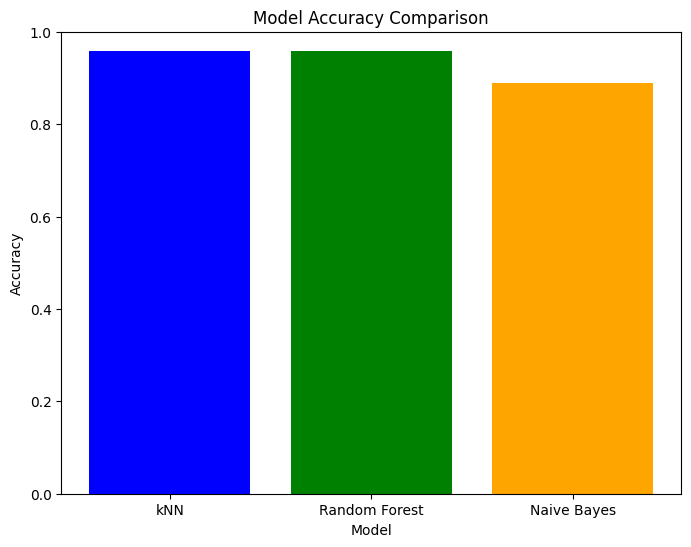

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming your preprocessed DataFrame is named 'df'
# Split the data into training and testing sets
X = df.drop('Retry', axis=1)  # Features
y = df['Retry']  # Target variable
X = X.to_numpy()
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models with parameters
models = {
    'kNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),  # Use distance-weighted neighbors
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Naive Bayes': GaussianNB()  # Adding Naive Bayes for comparison
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=1),
        'Recall': recall_score(y_test, y_pred, zero_division=1),
        'F1-Score': f1_score(y_test, y_pred, zero_division=1)
    }

# Print results
print("\nModel Performance:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")

# Visualization (example: Accuracy comparison)
model_names = list(results.keys())
accuracies = [results[model_name]['Accuracy'] for model_name in model_names]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for accuracy
plt.show()


aaaa
aaaa
aaaa


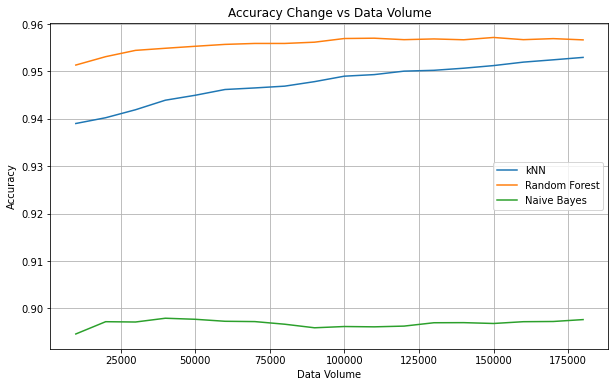

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, models are already defined
# Convert to numpy arrays for slicing

# Plot accuracy change vs data volume for each model
plt.figure(figsize=(10, 6))

for model_name, model in models.items():
    accuracy_scores = []
    data_volumes = range(10000, len(X_train) + 1, 10000)  # Vary data volume
    print('aaaa')
    for data_volume in data_volumes:
        # Fit the model with the subset of data
        model.fit(X_train[:data_volume], y_train[:data_volume])
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    plt.plot(data_volumes, accuracy_scores, label=model_name)

plt.title('Accuracy Change vs Data Volume')
plt.xlabel('Data Volume')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
